In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers

2022-11-29 18:59:57.991699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 18:59:58.054323: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 18:59:58.071866: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 18:59:58.426125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
# data
dataset_name = "oxford_flowers102"
num_epochs = 100  # train for at least 50 epochs for good results
image_size = 64
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 2

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 100
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:
import os
import cv2
from sklearn.model_selection import train_test_split


files = os.listdir("./mnist")
files = [f"./mnist/{filename}" for filename in files]

# train_files, test_files = train_test_split(
#     files,
#     test_size=0.1,
#     shuffle=True
# )

# print(len(train_files))
# print(len(test_files))

# train_files = train_files[:1000]
# test_files = test_files[:1000]

def data_generator(filename_list, batch_size=1):
    """Generator for read mp4 filename from training or testing folder,
    would yield each frame data in video and ground true label(class)
    """
    idx = 0
    while idx<len(filename_list):
        pixel_data_list = list()
        for j in range(batch_size):
            if idx>=len(filename_list):
                break
            mp4_filename = filename_list[idx]
            mp4_filename = mp4_filename.decode('ascii')
            pixel_data = cv2.imread(mp4_filename)
            pixel_data = tf.image.resize(pixel_data, size=[64, 64], antialias=True)
            pixel_data_list.append(pixel_data)
            idx += 1
        yield pixel_data_list

train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=(files, batch_size),
    output_types=(tf.float32),
    output_shapes=([None, image_size, image_size, 3])
)

# val_dataset = tf.data.Dataset.from_generator(
#     data_generator,
#     args=(test_files, batch_size),
#     output_types=(tf.float32),
#     output_shapes=([None, image_size, image_size, 3])
# )

2022-11-29 19:00:00.134723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:00:00.150397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:00:00.150493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:00:00.150924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [4]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [5]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        
        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=1, num_cols=8):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

Epoch 1/100


2022-11-29 19:00:44.887480: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-29 19:00:44.965724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-29 19:00:45.565259: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f42300b0860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-29 19:00:45.565276: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2022-11-29 19:00:45.568047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-29 19:00:45.625603: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      6/Unknown - 11s 276ms/step - n_loss: 0.7793WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0973s vs `on_train_batch_end` time: 0.1484s). Check your callbacks.
    600/Unknown - 172s 272ms/step - n_loss: 0.1058

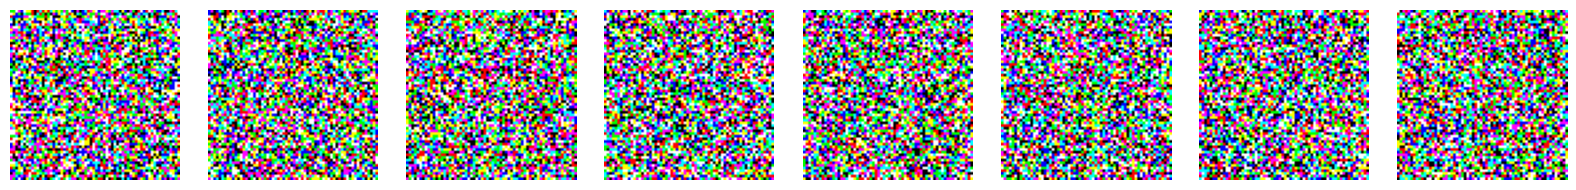

600/600 [==============================] - 173s 273ms/step - n_loss: 0.1058
Epoch 2/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0595
Epoch 3/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0493
Epoch 4/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0444
Epoch 5/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0416
Epoch 6/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0397
Epoch 7/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0376
Epoch 8/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0369
Epoch 9/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0353
Epoch 10/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0344
Epoch 11/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0337
Epoch 12/100
600/600 [====================

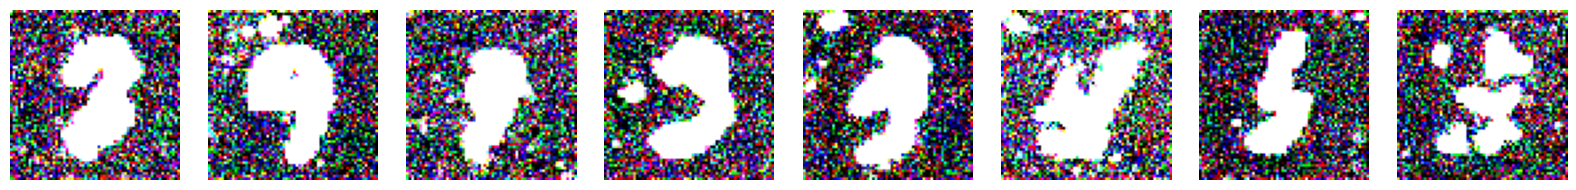

600/600 [==============================] - 163s 272ms/step - n_loss: 0.0317
Epoch 16/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0315
Epoch 17/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0308
Epoch 18/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0304
Epoch 19/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0306
Epoch 20/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0305
Epoch 21/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0300
Epoch 22/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0295
Epoch 23/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0293
Epoch 24/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0291
Epoch 25/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0290
Epoch 26/100
600/600 [============

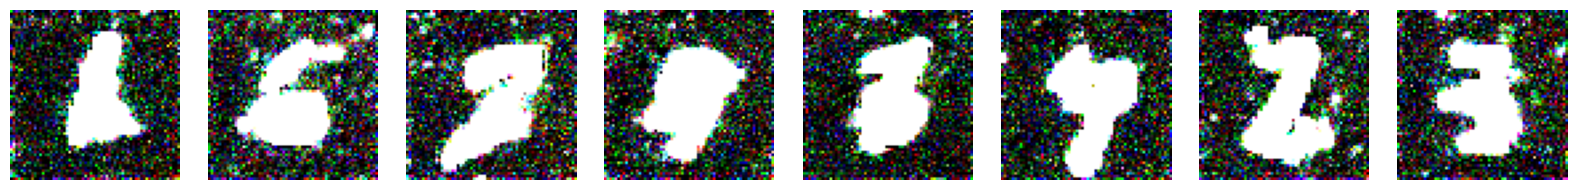

600/600 [==============================] - 163s 272ms/step - n_loss: 0.0283
Epoch 30/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0283
Epoch 31/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0283
Epoch 32/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0285
Epoch 33/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0284
Epoch 34/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0279
Epoch 35/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0278
Epoch 36/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0280
Epoch 37/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0279
Epoch 38/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0277
Epoch 39/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0277
Epoch 40/100
600/600 [============

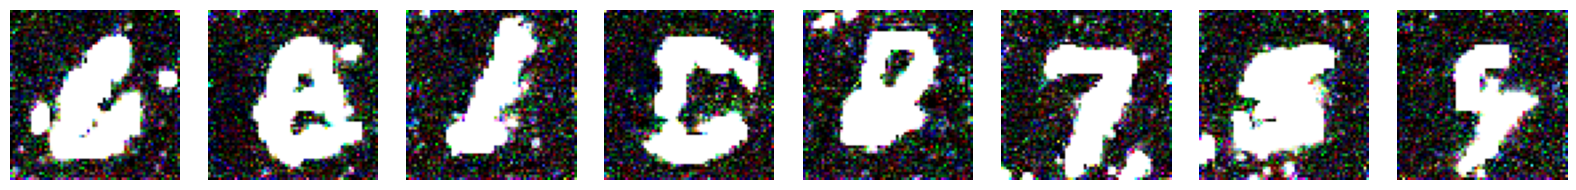

600/600 [==============================] - 163s 272ms/step - n_loss: 0.0272
Epoch 44/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0272
Epoch 45/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0273
Epoch 46/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0271
Epoch 47/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0270
Epoch 48/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0270
Epoch 49/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0270
Epoch 50/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0269
Epoch 51/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0268
Epoch 52/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0267
Epoch 53/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0266
Epoch 54/100
600/600 [============

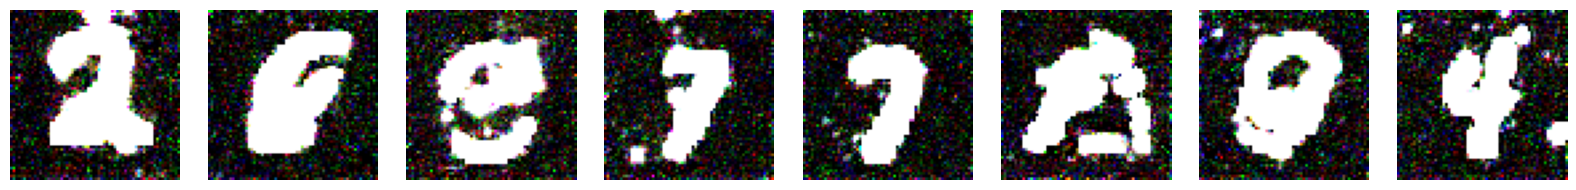

600/600 [==============================] - 163s 272ms/step - n_loss: 0.0265
Epoch 58/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0263
Epoch 59/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0264
Epoch 60/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0263
Epoch 61/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0262
Epoch 62/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0263
Epoch 63/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0264
Epoch 64/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0261
Epoch 65/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0261
Epoch 66/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0264
Epoch 67/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0265
Epoch 68/100
600/600 [============

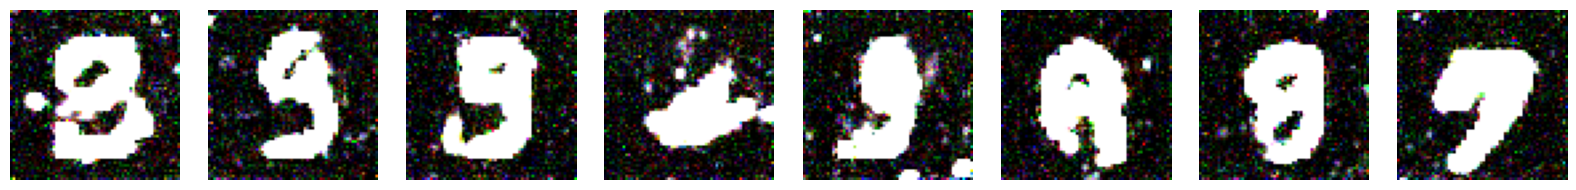

600/600 [==============================] - 164s 272ms/step - n_loss: 0.0260
Epoch 72/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0260
Epoch 73/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0261
Epoch 74/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0259
Epoch 75/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0259
Epoch 76/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0257
Epoch 77/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0259
Epoch 78/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0257
Epoch 79/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0257
Epoch 80/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0257
Epoch 81/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0256
Epoch 82/100
600/600 [============

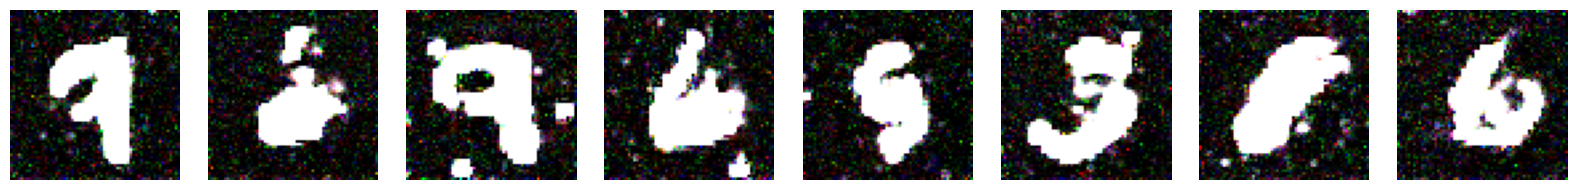

600/600 [==============================] - 163s 272ms/step - n_loss: 0.0256
Epoch 86/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0256
Epoch 87/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0255
Epoch 88/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0255
Epoch 89/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0256
Epoch 90/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0258
Epoch 91/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0253
Epoch 92/100
600/600 [==============================] - 164s 273ms/step - n_loss: 0.0256
Epoch 93/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0255
Epoch 94/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0252
Epoch 95/100
600/600 [==============================] - 164s 273ms/step - n_loss: 0.0255
Epoch 96/100
600/600 [============

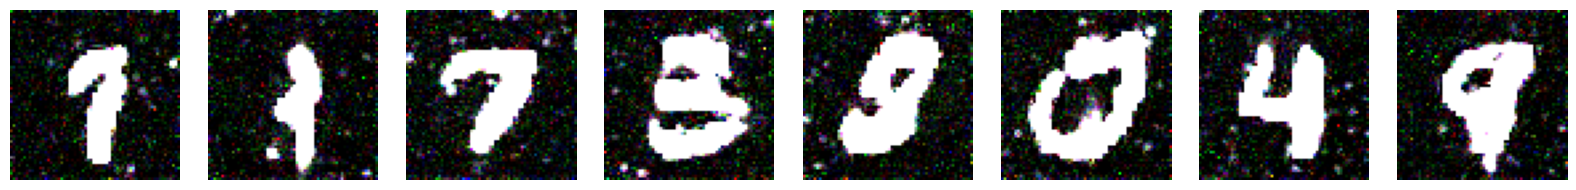

600/600 [==============================] - 164s 273ms/step - n_loss: 0.0253
Epoch 100/100
600/600 [==============================] - 163s 272ms/step - n_loss: 0.0252


In [6]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="train_loss",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % (int(num_epochs/7)) == 0:  
            self.model.plot_images()

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=[
        CustomSaver(),
        checkpoint_callback,
    ],
    workers=16
)

In [31]:
generated_images = model.generate(
    num_images=100,
    diffusion_steps=plot_diffusion_steps,
)

In [12]:
cv2.imwrite("result.png", generated_images[1].numpy())

True

In [32]:

for idx in range(20):
    print(generated_images[idx].shape)
    img = tf.image.resize(generated_images[idx], size=[28, 28], antialias=True)
    print(img.shape)
    
    plt.figure(figsize=(28/2,28/2), dpi=2)
    plt.imshow(img)

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{idx}.png", dpi=2)
    plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(28, 28, 3)
